In [1]:
import pandas as pd
import datetime as dt
from pytz import timezone
from pytz import UTC
import matplotlib.pyplot as plt
import numpy as np
import collections

In [2]:
%matplotlib inline

Import Energy Use Data & Wrangle

In [3]:
file_dir = './data/'
file_in = 'public_safety_center_MASTER_wrangled.csv'
file_out = ''

In [4]:
df = pd.read_csv(file_dir + file_in, index_col=0, header=False, skip_blank_lines=False, parse_dates=[1, 9])
header = df.columns.values

In [5]:
df = df.set_index('DateTime')

In [6]:
df.index = df.index.tz_localize('UTC')
df.index = df.index.tz_convert('US/Eastern')

In [7]:
df_daily_use = df.groupby(['Date'])['Use_kWh'].sum()

In [8]:
df_daily_use.to_csv(file_dir + 'public_safety_center_dailyenergyuse.csv', header=True, mode='w')

In [9]:
df_daily_use = df_daily_use.reset_index()

Import Weather Data & Wrangle

In [10]:
weather_dir = './data/NCDC/'
weather_file_in = 'NCDC_TotalWeather.csv'

In [11]:
df_weather = pd.read_csv(weather_dir + weather_file_in, header=False, skip_blank_lines=False, parse_dates=[0], usecols=[2,4,6])
df_weather.columns = ['Date', 'AvgTempF', 'AvgDewPF']

Merge Daily Use Data & Weather Data

In [12]:
df_merged = pd.merge(df_daily_use, df_weather, how='left', on='Date')

In [13]:
df_merged.to_csv(file_dir + 'public_safety_center_merged.csv', header=True, mode='w')

Testing Algorithms for Lean Energy Analysis

In [14]:
df_test = df.groupby(['Date'])['Use_kWh'].sum()
df_test = df_test.reset_index()

In [15]:
df_test_merged = pd.merge(df_daily_use, df_weather, how='left', on='Date')

In [16]:
# Insert fiscal year

def fiscal_year(val):
    if (val.month >= 7) and (val.month <=12):
        return val.year + 1
    else:
        return val.year
    
df_test_merged['FiscalYear'] = df_test_merged['Date'].apply(lambda x: fiscal_year(x))

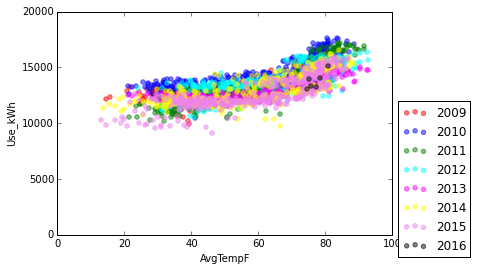

In [17]:
fig, ax = plt.subplots()

colors = {'2009':'red', '2010':'blue', '2011':'green', '2012':'cyan', '2013': 'magenta', '2014': 'yellow', '2015': 'violet', '2016': 'black'}

grouped = df_test_merged.groupby('FiscalYear')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='AvgTempF', y='Use_kWh', label=key, alpha=0.5, color=colors[str(key)])

plt.ylim([0,20000])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.25))
plt.show()

In [18]:
def ThreeP(df):
    x = np.asarray(df[~df['Use_kWh'].isnull()]['AvgTempF'])
    y = np.asarray(df[~df['Use_kWh'].isnull()]['Use_kWh'])
    dT = (np.round(x.max())-np.round(x.min()))/1000
    
    model = [[0,0,0],[0,0,0],[0,0,0]]

    for i in np.arange(np.round(x.min()), x.max(), dT):
        t_bp = x-i
        t_bp[t_bp < 0] = 0
        
        A = np.vstack([t_bp, np.ones(len(t_bp))]).T
        result = np.linalg.lstsq(A, y)
    
        b1 = result[0][1]
        b2 = result[0][0]
        b3 = i
    
        ss_tot = np.sum(np.power((y - np.mean((b1 + b2*t_bp))), 2))
        ss_res = result[1][0]
    
        r2 = 1 - (ss_res/ss_tot)
    
        if r2 > model[1][0]:
            model = [[b1, b2, b3],[r2, ss_res, ss_tot],[np.round(x.min()),x.max(),0]]
    
    return model

In [19]:
models = collections.OrderedDict()

for key, group in grouped:
    models.update({str(key):ThreeP(group)})

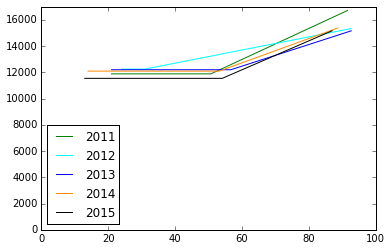

In [20]:
fig, ax = plt.subplots()

colors = {'2009':'red', '2010':'magenta', '2011':'green', '2012':'cyan', '2013': 'blue', '2014': 'darkorange', '2015': 'black', '2016': 'violet'}

for key, model in models.iteritems():
    if key in ['2011', '2012', '2013', '2014', '2015']:
        x = [model[2][0], model[0][2],model[2][1]]
        y = [model[0][0],model[0][0], model[0][0]+model[0][1]*(model[2][1]-model[0][2])]

        plt.plot(x, y, label=key, color=colors[key])

plt.ylim([0,17000])
plt.xlim([0,100])
plt.legend(loc='lower left')
plt.show()

In [21]:
df_load_factor = df.groupby(['Date'])['Use_kWh'].sum() / (df.groupby(['Date'])['P_kW'].max() * 24)
df_load_factor = df_load_factor.reset_index()
df_load_factor.columns = ['Date', 'DailyLoadFactor']

In [22]:
df_merged = pd.merge(df_test_merged, df_load_factor, how='left', on='Date')

In [23]:
df_merged['Month'] = df_merged['Date'].apply(lambda x: x.month)
df_merged['Day'] = df_merged['Date'].apply(lambda x: x.day)
df_merged['Year'] = df_merged['Date'].apply(lambda x: x.year)
df_merged['WeekDay'] = df_merged['Date'].apply(lambda x: x.weekday())

In [24]:
grouped_loadfactor = df_merged.groupby(['FiscalYear']).mean()['DailyLoadFactor']
grouped_loadfactor = grouped_loadfactor.reset_index()
grouped_loadfactor = grouped_loadfactor[grouped_loadfactor['FiscalYear'].isin([2011, 2012, 2013, 2014, 2015])]

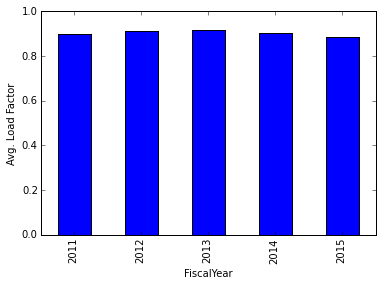

In [25]:
fig, ax = plt.subplots()
grouped_loadfactor.plot(ax=ax, kind='bar', x='FiscalYear', y='DailyLoadFactor', legend=None)
plt.ylim([0,1])
plt.ylabel('Avg. Load Factor')
plt.show()

In [26]:
test = df[df['FiscalYear']==2015].groupby(['Date', 'Hour'])['Use_kWh'].sum()

In [27]:
test = test.reset_index().groupby(['Date'])

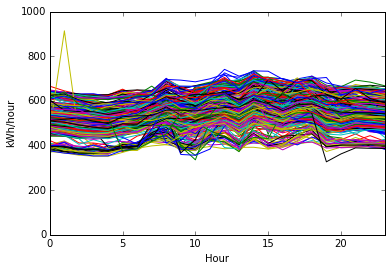

In [28]:
fig, ax = plt.subplots()

for key, group in test:
    group.plot(ax=ax, x='Hour', y='Use_kWh', legend=None)

plt.ylim([0,1000])
plt.ylabel('kWh/hour')
plt.show()

In [74]:
df_maxkW = df[df['FiscalYear']==2015].groupby(['Month'])['Use_kWh'].max()
df_maxkW = df_maxkW*2
df_maxkW

Month
1     614.4
2     626.0
3     600.4
4     604.0
5     696.0
6     754.2
7     751.6
8     726.2
9     741.8
10    719.8
11    585.4
12    583.6
Name: Use_kWh, dtype: float64

In [29]:
df_merged[df_merged['FiscalYear']==2015].columns.tolist()

['Date',
 'Use_kWh',
 'AvgTempF',
 'AvgDewPF',
 'FiscalYear',
 'DailyLoadFactor',
 'Month',
 'Day',
 'Year',
 'WeekDay']

In [30]:
df_DLF_weekday = df_merged[df_merged['FiscalYear']==2015].groupby(['WeekDay']).mean()['DailyLoadFactor']
df_DLF_weekday

WeekDay
0    0.877379
1    0.877953
2    0.879420
3    0.885569
4    0.886332
5    0.893427
6    0.892643
Name: DailyLoadFactor, dtype: float64

In [31]:
df_DLF_month = df_merged[df_merged['FiscalYear']==2015].groupby(['Month']).mean()['DailyLoadFactor']
df_DLF_month

Month
1     0.874226
2     0.851592
3     0.866715
4     0.879590
5     0.890588
6     0.881020
7     0.893078
8     0.892588
9     0.907492
10    0.901109
11    0.895184
12    0.880290
Name: DailyLoadFactor, dtype: float64

In [75]:
df_DLF_monthtemp = df_merged[df_merged['FiscalYear']==2015].groupby(['Month']).mean()[['DailyLoadFactor', 'AvgTempF']]

In [76]:
df_DLF_maxkWmonthtemp = pd.merge(df_DLF_monthtemp.reset_index(), df_maxkW.reset_index(), how='left', on='Month')
df_DLF_maxkWmonthtemp = df_DLF_maxkWmonthtemp.rename(columns = {'Use_kWh':'MaxkW'})
df_DLF_maxkWmonthtemp

,Month,DailyLoadFactor,AvgTempF,MaxkW
0,1,0.874226,35.490323,614.4
1,2,0.851592,30.017857,626.0
2,3,0.866715,44.535484,600.4
3,4,0.879590,59.526667,604.0
4,5,0.890588,72.425806,696.0
5,6,0.881020,77.603333,754.2
6,7,0.893078,78.970968,751.6
7,8,0.892588,77.519355,726.2
8,9,0.907492,73.186667,741.8
9,10,0.901109,62.938710,719.8


(0, 1)

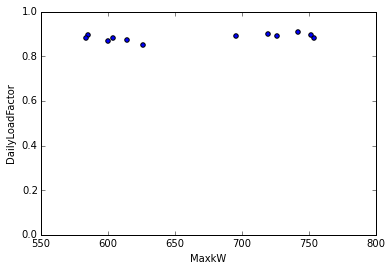

In [77]:
fig, ax = plt.subplots()

df_DLF_maxkWmonthtemp.plot(ax=ax, kind='scatter', x='MaxkW', y='DailyLoadFactor', legend=None)
plt.ylim([0,1])

In [32]:
df_DLF_monthtemp = df_merged[df_merged['FiscalYear']==2015].groupby(['Month']).mean()[['DailyLoadFactor', 'AvgTempF']]
df_DLF_monthtemp

,DailyLoadFactor,AvgTempF
Month,,
1,0.874226,35.490323
2,0.851592,30.017857
3,0.866715,44.535484
4,0.879590,59.526667
5,0.890588,72.425806
6,0.881020,77.603333
7,0.893078,78.970968
8,0.892588,77.519355
9,0.907492,73.186667


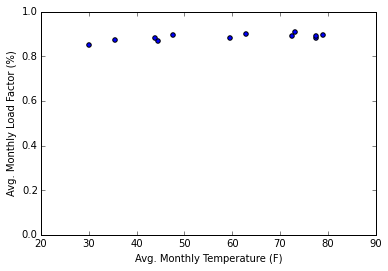

In [33]:
fig, ax = plt.subplots()

df_DLF_monthtemp.plot(ax=ax, kind='scatter', x='AvgTempF', y='DailyLoadFactor', legend=None)

plt.ylim([0,1])
plt.ylabel('Avg. Monthly Load Factor (%)')
plt.xlabel('Avg. Monthly Temperature (F)')
plt.show()

In [34]:
df_DLF_monthweekday = df_merged[df_merged['FiscalYear']==2015].groupby(['WeekDay', 'Month']).mean()[['DailyLoadFactor']]
df_DLF_monthweekday

DailyLoadFactor
WeekDay Month                 
0       1             0.858981
        2             0.816385
        3             0.868276
        4             0.873522
        5             0.886561
        6             0.866833
        7             0.877734
        8             0.891895
        9             0.909627
        10            0.901170
        11            0.892872
        12            0.880705
1       1             0.866017
        2             0.869250
        3             0.850649
        4             0.868383
        5             0.884313
        6             0.869388
        7             0.892074
        8             0.880378
        9             0.897052
        10            0.882848
        11            0.894597
        12            0.880518
2       1             0.864260
        2             0.847522
        3             0.865376
        4             0.872468
        5             0.891157
        6             0.885447
...                        ...
4       7             0.893788
        8             0.885197
        9             0.915564
        10            0.908525
        11            0.896139
        12            0.869371
5       1             0.885354
        2             0.859759
        3             0.869635
        4             0.886109
        5             0.893165
        6             0.897692
        7             0.912757
        8             0.900869
        9             0.922551
        10            0.918887
        11            0.895038
        12            0.879127
6       1             0.880691
        2             0.856096
        3             0.871167
        4             0.878190
        5             0.903519
        6             0.892192
        7             0.899042
        8             0.907009
        9             0.922745
        10            0.913567
        11            0.899165
        12            0.885766

[84 rows x 1 columns]

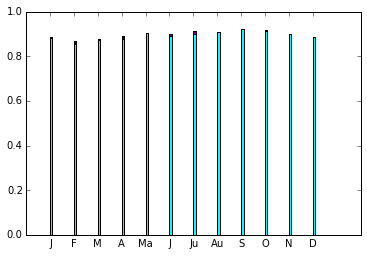

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)

ind = np.arange(12)  # the x locations for the groups
N = 12
w = np.linspace(-0.2, 0.2, 12)

    
color = {'0': 'red', '1': 'blue', '2': 'green', '3': 'magenta', '4': 'orange', '5': 'purple', '6': 'aqua'}
label = {'0': 'Monday', '1': 'Tuesday', '2': 'Wednesday', '3': 'Thursday', '4': 'Friday', '5': 'Saturday', '6': 'Sunday'}

for key, group in df_DLF_monthweekday.iteritems():
    reset = group.reset_index()

    for i in arange(0,7):
        y = reset[reset['WeekDay']==i][key].values.tolist()
        x = reset[reset['WeekDay']==i]['Month'].values.tolist()
        
        ax.bar(x,y,width=0.1,color=color[str(i)], label=label[str(i)])
        
#plt.set_xtick(ind+width)
ax.set_xlim([0, 14])
ax.set_xticks(arange(0,13))
ax.set_xticklabels(['', 'J', 'F', 'M', 'A', 'Ma', 'J', 'Ju', 'Au', 'S', 'O', 'N', 'D', ''])